# Abstract
First using the Linear Discriminant Analysis to classify Mnist dataset, and observe its confusion matrix.\
Second, using the ROSELAND to find out the nonlinear manifold surface of data to analysis why misclassified.

## Algorithm

In [ ]:
%pylab inline
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.sparse import dia_matrix
import scipy
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform, cdist, pdist
import random
from sklearn.neighbors import KNeighborsClassifier

Populating the interactive namespace from numpy and matplotlib


### Algorithm - Roseland

In [ ]:
class ROSELAND:
  def __init__(self, sigma, clusters, opt = 'glob'):
    self.sigma = sigma
    self.clusters = clusters
    self.opt = opt

  def train(self, data, land):
    if(len(data.shape) == 2):
      self.n, self.p = data.shape
      self.m, self.q = land.shape
    elif(len(data.shape) == 3):  
      self.n, self.p1, self.p2 = data.shape
      self.m, self.q1, self.q2 = land.shape
    W_r = self.get_W(data, land) # construct affinity matrix
    eig_vals, EMB = self.get_eig(W_r) # SVD
    Y = self.get_Y(eig_vals, EMB)
    
  def get_W(self, data, landmark):
    if(len(data.shape) == 3):
      data = np.array([data[i].reshape(1, self.p1 * self.p2) for i in range(self.n)]).reshape(self.n, self.p1 * self.p2)
      landmark = np.array([landmark[i].reshape(1, self.q1 * self.q2) for i in range(self.m)]).reshape(self.m, self.q1 * self.q2)
    W = cdist(data, landmark)
    W_sort = sort(W, 1)
    print(W.shape)
    if(self.opt == 'glob'):
      #2 * average(W_sort) ** 2
      sigma =2 * percentile(W_sort[:, self.sigma + 1], 50) ** 2  
      print(sigma)
      W = exp(- W.dot(W.T) / sigma) 
    elif(self.opt == 'local'):
      Distsort = sort(W, axis = 0)
      tmp = Distsort[self.sigma + 1, :]
      tmp[argwhere(tmp == 0)] = 1e-5
      sigmasm = diag(1 / tmp)
      
      Distsort = sort(W, axis = 1)
      tmp = Distsort[:, self.sigma + 1]
      tmp[argwhere(tmp == 0)] = 1e-5
      sigmabg = dia_matrix((1 / tmp, 0), shape = (self.n, self.n))

      W = exp(-sigmabg.dot(W * W).dot(sigmasm))
    print(W)
    return W
  
  def get_eig(self, W):
    s = sum(W.dot(W.T), axis = 1)
    D = diag(1 / pow(s, 0.5))
    Q = D.dot(W)
    
    U,S,V = svds(Q, c + 1)
    eigenvals = S[::-1]
    self.eigenvals = eigenvals
    eigenvals = diag(eigenvals * eigenvals)

    U = U[:, ::-1]

    EMB = D.dot(U)
    self.emb = EMB
    return eigenvals, EMB
  
  def get_Y(self, eigenvals, EMB):
    EMB = EMB / np.linalg.norm(EMB)
    self.Y = EMB.dot(eigenvals)
    return self.Y  

### Algorithm-LDA

In [ ]:
class LDA:
  def __init__(self, d):
    self.d = d
    self.W = 0
  def fit(self, x_train, y_train):
    if len(x_train.shape) == 3:
      self.n, p1, p2 = x_train.shape
      self.p = p1 * p2
      x_train = np.array([x_train[i].reshape(1, self.p) for i in range(self.n)]).reshape(self.n, self.p)
    self.k=len(np.unique(y_train))
    #Classification
    X=[[] for i in range(self.k)]; mu=[]; t=0
    for i in y_train:
      j = int(np.where(np.unique(y_train) == i)[0])
      X[j].append(x_train[t]); t = t + 1
    #Sw & Sb
    Sw = np.zeros((self.p , self.p))
    for j in range(self.k):
      Sw += np.cov(np.matrix(X[j]).T)
    St = np.cov(x_train.T)
    Sb = St - Sw
    Sw = Sw + 0.00001 * np.identity(Sw.shape[0])  # let Sw be positive deinite
    #find W 
    #Sb^-1SW
    eigen_vals, eigen_vecs = scipy.linalg.eigh(Sb, Sw)
    eigen_pairs = [(eigen_vals[i], eigen_vecs[:, i]) for i in range(len(eigen_vals))]
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
    W = eigen_pairs[0][1][:, np.newaxis].real
    for i in range(1, self.d):
      W = np.hstack((W, eigen_pairs[i][1][:, np.newaxis].real))
    print(W)
    self.W=W
    B = np.dot(x_train, self.W)
    self.knn = KNeighborsClassifier()
    self.knn.fit(B, y_train)
    return B

  def plot(self, plt, B, y):
    fig, ax = plt.subplots(figsize=(8,8))
    scatter = ax.scatter(B[:, 0], B[:, 1], s = 5, alpha = 0.6, c = y[:], cmap = 'rainbow')

    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    plt.title('LDA space') 
    plt.show()

  def predict(self, x_test):
    if len(x_test.shape) == 3:
      self.n2, q1, q2 = x_test.shape
      self.q = q1 * q2    
      x_test = np.array([x_test[i].reshape(1, self.q) for i in range(self.n2)]).reshape(self.n2, self.q)
    x_pred = np.dot(x_test, self.W)
    # use knn to find the each prediction(0/1)
    y_pred = self.knn.predict(x_pred)
    return y_pred

  def score(self, y_pred, Y):
    num = []; num_len = []
    ind = np.unique(Y)
    for i in range(self.k): num.append([])
    for i in range(self.k): num[i] = array(np.where(Y == ind[i]))[0]; num_len.append(len(num[i]))
    cm = np.zeros((self.k, self.k))
    score = np.zeros(self.k);
    for i in range(len(Y)):
      a = int(np.where(ind==y_pred[i])[0])
      b = int(np.where(ind==Y[i])[0])
      cm[a][b] += 1
      if y_pred[i] == Y[i]: score[b] += 1
    for i in range(self.k): score[i] = score[i] / num_len[i]
    self.confusion_matrix = cm
    self.ind = ind
    return score
  def draw_CM(self):
    CM = np.zeros((self.k + 1, self.k + 1))
    for i in range(1, self.k + 1):
      CM[0][i] = self.ind[i - 1]; CM[i][0] = self.ind[i-1]
    CM[1:, 1:] = self.confusion_matrix
    CM = np.asarray(CM, dtype = int)
    print(CM)

In [ ]:
def confusion_matrix(y_pred, Y):
  k, ind, confusion_matrix = cm(y_pred, Y)
  draw_CM(k, ind, confusion_matrix)
  return confusion_matrix
def cm(y_pred, Y):
  num = []; num_len = []
  ind = np.unique(Y)
  k = len(ind)
  for i in range(k): num.append([])
  for i in range(k): num[i] = array(np.where(Y == ind[i]))[0]; num_len.append(len(num[i]))
  cm = np.zeros((k, k))
  score = np.zeros(k);
  for i in range(len(Y)):
    a = int(np.where(ind==y_pred[i])[0])
    b = int(np.where(ind==Y[i])[0])
    cm[a][b] += 1
    if y_pred[i] == Y[i]: score[b] += 1
  for i in range(k): score[i] = score[i] / num_len[i]
  confusion_matrix = cm
  return k, ind, confusion_matrix
  
def draw_CM(k, ind, confusion_matrix):
  CM = np.zeros((k + 1, k + 1))
  for i in range(1, k + 1):
    CM[0][i] = ind[i - 1]; CM[i][0] = ind[i-1]
  CM[1:, 1:] = confusion_matrix
  CM = np.asarray(CM, dtype = int)
  print(CM)

### Loading data

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [ ]:
from scipy import stats
n, p1, p2 = trainX.shape
p = p1 * p2
#x_train = np.array([trainX[i].reshape(1, p) for i in range(n)]).reshape(n, p)
shapiro_test = stats.shapiro(trainX)
shapiro_test
#shapiro_test.statistic

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.550279974937439, 0.0)

In [ ]:
tr_num = []; tr_num_len = []; te_num = []; te_num_len = []
for i in range(10): tr_num.append([]); te_num.append([])
for i in range(10): 
  tr_num[i] = array(np.where(trainy == i))[0]; tr_num_len.append(len(tr_num[i]));
  te_num[i] = array(np.where(testy == i))[0]; te_num_len.append(len(te_num[i]));

In [ ]:
q = []; qind = []
for i in range(10): q.append(trainX[tr_num[i]][0]); qind.append([])
for j in range(10):
  for i in range(28):
    if np.array_equal(q[j][i], np.zeros(28)) is False: qind[j].append(i)
for j in range(10):
  print(len(qind[j]), qind[j])

20 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
20 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
20 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
20 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


## Mnist data classified by LDA(10 classes)


The dimension that LDA maximun can be reduced to <= min(n_classes - 1, n_features)\
Since $S_{between}$ is the sum of $C$ different rank 1 matrices, $rank(S_{between}) < C$

Original data is $10$ classes and $28 \times 28$ dimension\
$min(10-1, 28*28) = 9$\
using LDA such that the new data is $9$ dimension

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA(n_components = 4)
n, p1, p2 = trainX.shape
p = p1 * p2
m, q1, q2 = testX.shape
q = q1 * q2
x_train = np.array([trainX[i].reshape(1, p) for i in range(n)]).reshape(n, p)
x_test = np.array([testX[i].reshape(1, q) for i in range(m)]).reshape(m, q)
model.fit(x_train, trainy)
y_pred = model.predict(x_test)
model.score(x_test, testy)

0.873

In [ ]:
model.transform(x_train).shape

(60000, 9)

In [ ]:
CM = confusion_matrix(y_pred, testy)

[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  940    0   15    5    0    8   12    2    7    9]
 [   1    0 1096   32    5   12    8    8   30   27    7]
 [   2    1    4  816   25    6    4   11   15    8    1]
 [   3    4    3   34  883    0   44    0    9   27   13]
 [   4    2    2   21    4  888   12   25   22   20   63]
 [   5   13    2    5   25    4  735   29    2   53    6]
 [   6    9    3   37    3    7   15  857    0   10    0]
 [   7    1    0    9   16    2   10    0  864    6   37]
 [   8    9   25   57   29   10   38   16    4  790   12]
 [   9    1    0    6   15   53   18    0   80   26  861]]


In [ ]:
k, ind, confusion_matrix = cm(y_pred, testy)
confusion_matrix = np.asarray(confusion_matrix, dtype = int)

In [ ]:
accuracy = []
for i in range(10):
  print(i, ':', str(round((CM[i, i]/(sum(CM[:, i]))) * 100, 2)) + '%')

0 : 95.92%
1 : 96.56%
2 : 79.07%
3 : 87.43%
4 : 90.43%
5 : 82.4%
6 : 89.46%
7 : 84.05%
8 : 81.11%
9 : 85.33%


## Apply roseland on each digit

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
#data = model.transform(x_train)[:20000]
data = x_train[:20000]
datay = trainy[:20000]
clusters = len(np.unique(datay))         #the number of groups of data
c = clusters - 1      #the number of the eigenvalues we computed
n, p = data.shape
print(n, p)

20000 784


In [ ]:
beta = .5
m = round(pow(n,beta))
subi = range(int(n / m) - 1, n, int(n / m))
land = data[subi, :]
landmark_size = land.shape[0]

In [ ]:
start = time.time()
roseland = ROSELAND(7, clusters, opt = 'local')
roseland.train(data, land)
end = time.time()
print(end - start)
%time

(20000, 141)
[[0.16291165 0.14996279 0.08670911 ... 0.00942641 0.1408236  0.003419  ]
 [0.08158044 0.09486997 0.05434152 ... 0.00377412 0.10087045 0.00139109]
 [0.10096673 0.12822843 0.07545963 ... 0.00330501 0.04420343 0.00275873]
 ...
 [0.1496582  0.07872275 0.11856876 ... 0.04171649 0.06983498 0.00774995]
 [0.13481614 0.06618221 0.08780898 ... 0.04141775 0.05394541 0.02337826]
 [0.11224108 0.10466407 0.07429504 ... 0.01281245 0.15559949 0.00665815]]
27.355384588241577
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 16.7 µs


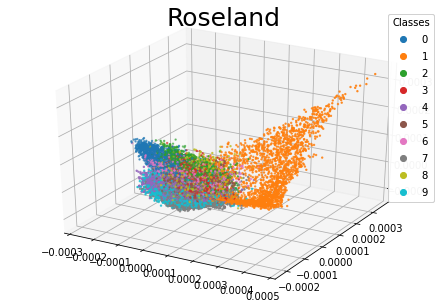

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

color = ['black', 'purple', 'dark_blue', 'b', 'dark_green', 'yellow', 'orange', 'red', 'pink', 'brown']
datay = datay.reshape(datay.shape[0], 1)
scatter = ax.scatter(roseland.Y[:, 1], roseland.Y[:, 2], roseland.Y[:, 3], s=2, c = datay[:], cmap = 'tab10')

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.title('Roseland', fontsize = 25) 
plt.show()

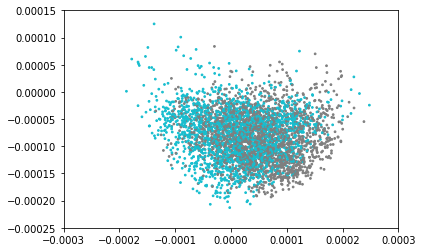

In [ ]:
k = [7, 9]
plt.figure(figsize=(6, 4))
size = [int(np.isin(i, k)) * 3 for i in datay]
plt.scatter(roseland.Y[:, 1], roseland.Y[:, 2], s = size[:], c = datay[:], cmap = 'tab10')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
'''
plt.xlim(-0.002, 0.001)
plt.ylim(-0.003, 0.002)
'''

plt.xlim(-0.0003, 0.0003)
plt.ylim(-0.00025, 0.00015)

#plt.title('digit ' + str(k), fontsize = 25)
#ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
plt.show()

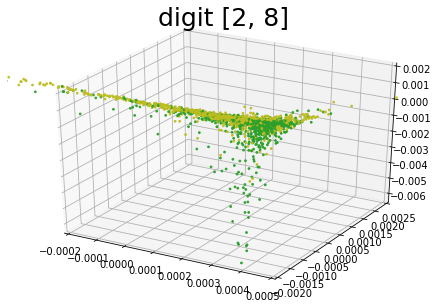

In [ ]:
k = [2, 8]
fig = plt.figure()
ax = Axes3D(fig)
size = [int(np.isin(i, k)) * 3 for i in datay]
ax.scatter(roseland.Y[:, 1], roseland.Y[:, 2], roseland.Y[:, 3], s = size[:], c = datay[:], cmap = 'tab10')
#legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
#ax.add_artist(legend1)

plt.xlim(-0.0002, 0.0005)
plt.ylim(-0.002, 0.0025)

plt.title('digit ' + str(k), fontsize = 25)
plt.show()

In [ ]:
a = [0, 1, 15, 21, 125, 150, 64, 66, 33, 173]
for i in a:
  print(tr_num[2][800:1000][i])

8154
8201
8372
8428
9383
9658
8834
8843
8552
9830


<Figure size 720x432 with 0 Axes>

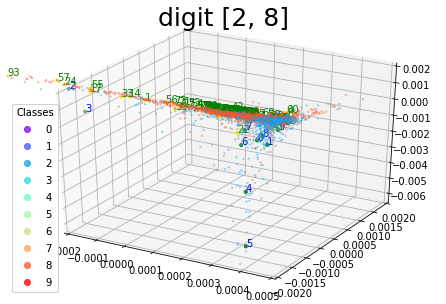

In [ ]:
k = [2, 8]
plt.figure(figsize=(10,6))
d1 = [8154,
8201,
8372,
8428,
9383,
9658,
8834,
8843,
8552,
9830]
d2 =tr_num[8][:100]

fig = plt.figure()
ax = Axes3D(fig)
size = [int(np.isin(i, k)) * 2 for i in datay]
#size = [int(i==8) * 2 for i in datay]
ax.scatter(roseland.Y[:, 1], roseland.Y[:, 2], roseland.Y[:, 3], s = size[:], alpha = 0.3, c = datay[:], cmap = 'rainbow')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)


ax.scatter(roseland.Y[d1, 1], roseland.Y[d1, 2], roseland.Y[d1, 3], s = 10, c = 'green')
ax.scatter(roseland.Y[d2, 1], roseland.Y[d2, 2], roseland.Y[d2, 3], s = 10, c = 'yellow')

for i in range(len(d1)):
  ax.text(roseland.Y[d1[i], 1], roseland.Y[d1[i], 2], roseland.Y[d1[i], 3], str(i), c = 'b')

for i in range(len(d2)):
  ax.text(roseland.Y[d2[i], 1], roseland.Y[d2[i], 2], roseland.Y[d2[i], 3], str(i), c = 'g')

plt.xlim(-0.0002, 0.0005)
plt.ylim(-0.002, 0.002)

plt.title('digit ' + str(k), fontsize = 25)
plt.show()


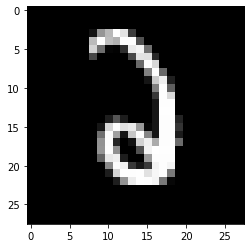

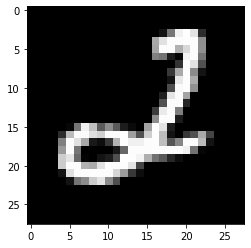

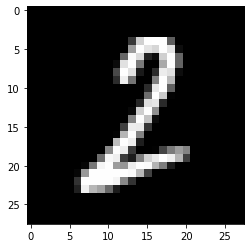

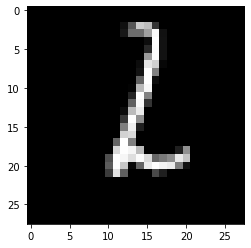

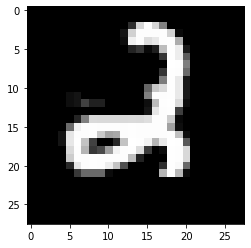

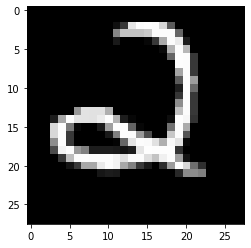

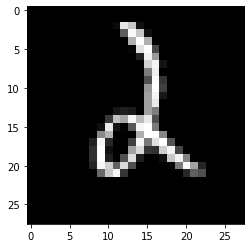

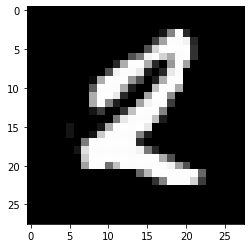

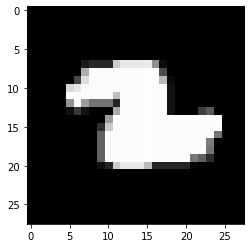

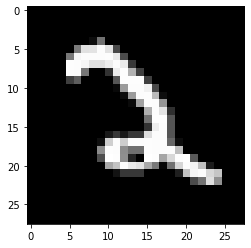

In [ ]:
for i in range(len(d1)):
  plt.imshow(trainX[d1[i]], cmap=plt.get_cmap('gray'))
  plt.show()

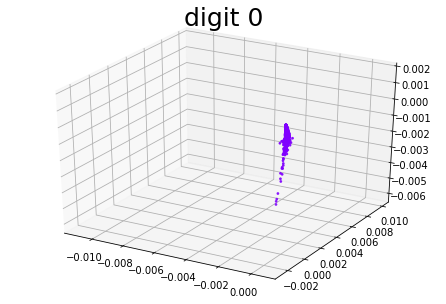

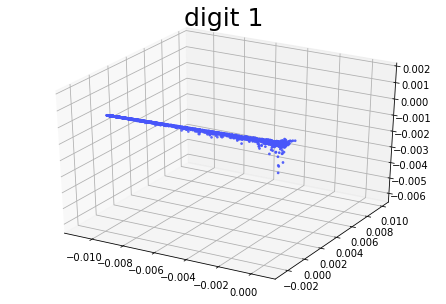

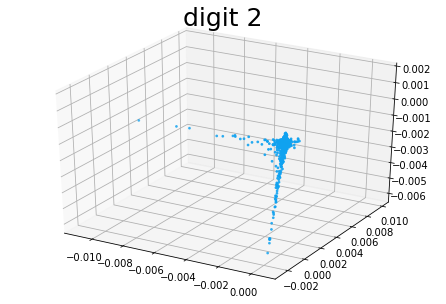

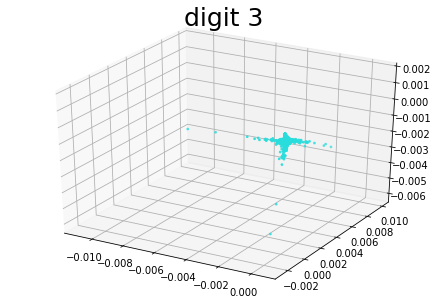

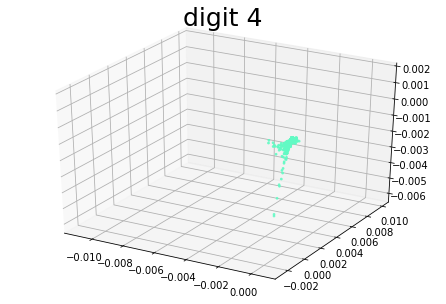

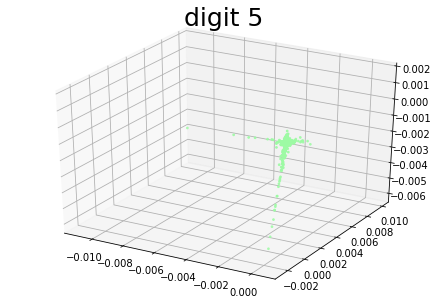

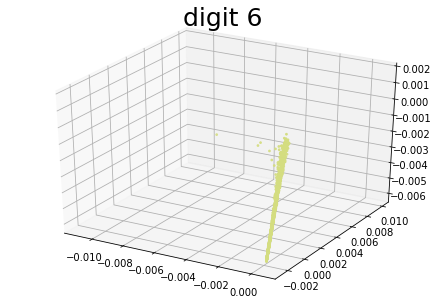

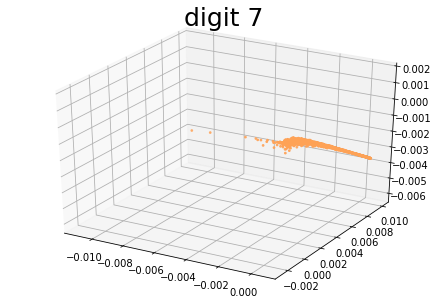

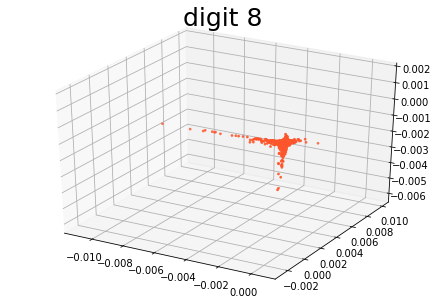

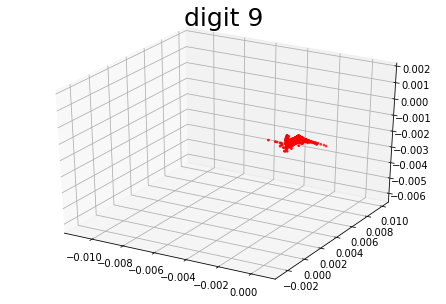

In [ ]:
for k in range(10):
  fig = plt.figure()
  ax = Axes3D(fig)
  size = [int(i == k) * 3 for i in datay]
  ax.scatter(roseland.Y[:, 1], roseland.Y[:, 2], roseland.Y[:, 3], s = size[:], c = datay[:], cmap = 'rainbow')
  plt.title('digit ' + str(k), fontsize = 25)
  plt.show()